### Data Loading

In [212]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report


In [231]:
clients = pd.read_csv('../data/processed/clients.csv')
orders = pd.read_csv('../data/processed/orders.csv')
orders_raw = pd.read_csv('../data/processed/orders_raw.csv')
clients_monthly = pd.read_csv('../data/processed/clients_monthly.csv')

### Efficiency Distribution

In [232]:
# Update efficient_clients and inefficient_clients with the encoded dataframe
efficient_clients = clients[clients['efficiency'] >= 1].copy()
inefficient_clients = clients[clients['efficiency'] < 1].copy()

total_clients = len(clients)
num_efficient = len(efficient_clients)
num_inefficient = len(inefficient_clients)
pct_efficient = num_efficient / total_clients * 100
pct_inefficient = num_inefficient / total_clients * 100

print(f"Number of efficient clients: {num_efficient} ({pct_efficient:.1f}%)")
print(f"Number of inefficient clients: {num_inefficient} ({pct_inefficient:.1f}%)")

inefficient_clients['class'].value_counts()


Number of efficient clients: 34273 (81.7%)
Number of inefficient clients: 7677 (18.3%)


class
HighTicket_Inefficient    4137
LowTicket_Inefficient     3540
Name: count, dtype: int64

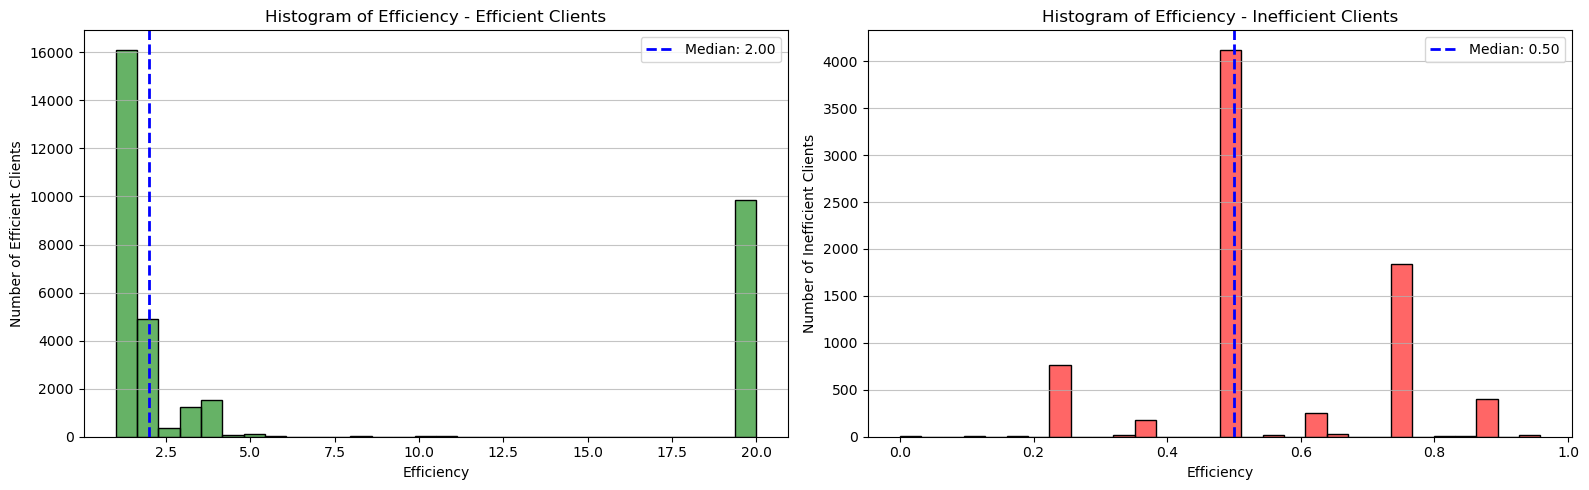

In [215]:
# Plot histograms of efficiency for efficient and inefficient clients side by side, marking the median
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Efficient Clients
sns.histplot(efficient_clients['efficiency'], bins=30, color='green', edgecolor='black', alpha=0.6, ax=axes[0])
median_efficient = efficient_clients['efficiency'].median()
axes[0].axvline(median_efficient, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_efficient:.2f}')
axes[0].set_title('Histogram of Efficiency - Efficient Clients')
axes[0].set_xlabel('Efficiency')
axes[0].set_ylabel('Number of Efficient Clients')
axes[0].grid(axis='y', alpha=0.75)
axes[0].legend()

# Inefficient Clients
sns.histplot(inefficient_clients['efficiency'], bins=30, color='red', edgecolor='black', alpha=0.6, ax=axes[1])
median_inefficient = inefficient_clients['efficiency'].median()
axes[1].axvline(median_inefficient, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_inefficient:.2f}')
axes[1].set_title('Histogram of Efficiency - Inefficient Clients')
axes[1].set_xlabel('Efficiency')
axes[1].set_ylabel('Number of Inefficient Clients')
axes[1].grid(axis='y', alpha=0.75)
axes[1].legend()

plt.tight_layout()
plt.show()


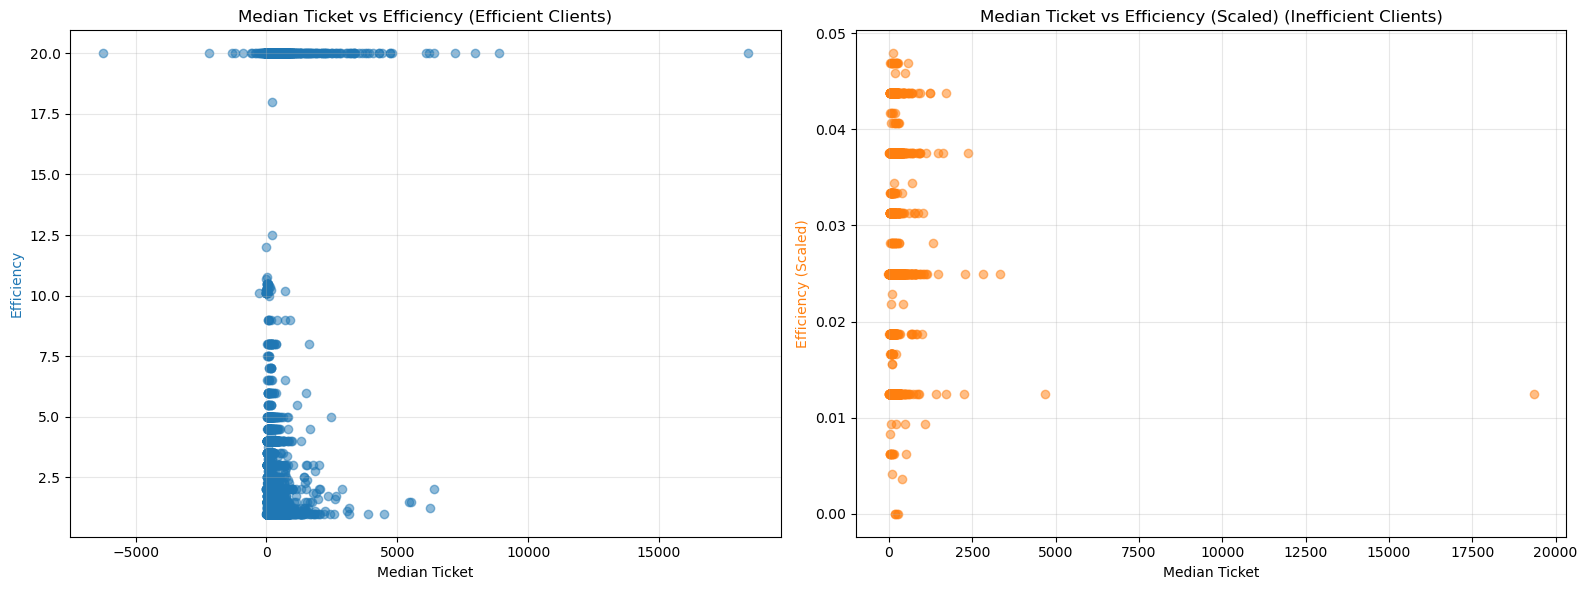

In [216]:
# Plot side by side: Efficiency vs Median Ticket (Efficient) and Efficiency (Scaled) vs Median Ticket (Inefficient)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Efficient clients
axes[0].scatter(efficient_clients['median_ticket'], efficient_clients['efficiency'], alpha=0.5, color='tab:blue', label='Efficiency')
axes[0].set_xlabel('Median Ticket')
axes[0].set_ylabel('Efficiency', color='tab:blue')
axes[0].set_title('Median Ticket vs Efficiency (Efficient Clients)')
axes[0].grid(True, alpha=0.3)

# Right plot: Inefficient clients
axes[1].scatter(inefficient_clients['median_ticket'], inefficient_clients['efficiency_scaled'], alpha=0.5, color='tab:orange', label='Efficiency (Scaled)')
axes[1].set_xlabel('Median Ticket')
axes[1].set_ylabel('Efficiency (Scaled)', color='tab:orange')
axes[1].set_title('Median Ticket vs Efficiency (Scaled) (Inefficient Clients)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [217]:
clients

,client_id,city,channel,promotor_id,frequency,efficiency,efficiency_scaled,total_orders,total_volume,total_income,...,median_promotor_calls,total_promotor_calls,class,zero_visit_flag,avg_orders_per_month,avg_visits_per_month,visit_order_gap,inefficiency_cost,profit_per_visit,opportunity_cost
0,100006690,Madrid,AR,275609911,2.0,1.00,0.0500,22,1658.706,1494.53,...,0.0,0.0,LowTicket_Efficient,False,1.833333,2.000000,0.166667,2.50,25.605417,4.267569
1,100008050,Barcelona,AR,368568690,1.0,20.00,1.5000,14,3982.000,1905.59,...,2.0,20.0,HighTicket_Efficient,True,1.166667,0.000000,-1.166667,-17.50,0.000000,-0.000000
2,100042162,Barcelona,HR,455263770,1.0,0.25,0.0125,14,1812.850,2243.30,...,0.0,0.0,HighTicket_Inefficient,False,1.166667,3.666667,2.500000,37.50,28.711364,71.778409
3,100046227,Barcelona,AR,454554895,4.0,2.00,0.1000,16,4590.180,2273.12,...,2.0,8.0,HighTicket_Efficient,False,1.333333,0.666667,-0.666667,-10.00,204.140000,-136.093333
4,100125158,Cadiz,HR,483340469,3.0,3.00,0.1500,25,1266.500,2204.24,...,0.0,0.0,HighTicket_Efficient,False,2.083333,0.833333,-1.250000,-18.75,157.924000,-197.405000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41945,999934164,Barcelona,HR,480416490,2.0,2.00,0.1000,23,691.000,785.30,...,3.0,27.0,LowTicket_Efficient,False,1.916667,0.750000,-1.166667,-17.50,23.366667,-27.261111
41946,999940211,Barcelona,AR,908993212,1.0,20.00,1.5000,3,557.820,260.55,...,0.0,0.0,LowTicket_Efficient,True,0.250000,0.000000,-0.250000,-3.75,0.000000,-0.000000
41947,999940578,Madrid,AR,275609911,1.0,0.50,0.0250,13,1101.524,1044.61,...,0.0,0.0,LowTicket_Inefficient,False,1.083333,1.833333,0.750000,11.25,23.845909,17.884432
41948,999941988,Madrid,AR,677360818,3.0,1.50,0.0750,36,5415.150,3828.31,...,2.0,24.0,HighTicket_Efficient,False,3.000000,2.000000,-1.000000,-15.00,100.762917,-100.762917


### Step-wise Function

In [218]:
import statsmodels.api as sm
import pandas as pd

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection based on p-value.
    
    Returns:
        A tuple containing two lists: (selected_features, removed_features)
    """
    included = list(initial_list)
    removed = []  # Initialize a new list to track removed features

    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.4f}'.format(best_feature, best_pval))
            # If a feature that was previously removed is added back, remove it from the removed list
            if best_feature in removed:
                removed.remove(best_feature)

        # backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            # Add the removed feature to our tracking list
            if worst_feature not in removed:
                removed.append(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.4f}'.format(worst_feature, worst_pval))
        if not changed:
            break
            
    return included, removed # Return both the included and removed lists

### 1. Initial Cleaning and Target Creation


In [219]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# clients.drop(columns=['efficiency', 'efficiency_scaled'], inplace=True)

# clients['efficiency'] = (clients['frequency']/clients['median_promotor_visits'])
# clients.loc[(clients['frequency'] == 0),'efficiency'] = 0    
# clients['efficiency'] = clients['efficiency'].replace([np.inf, -np.inf], np.inf)

# # Step 1: Separate finite and infinite values
# finite_mask = np.isfinite(clients['efficiency'])
# infinite_mask = ~finite_mask

# # Step 2: Scale only finite values
# scaler = MinMaxScaler()
# clients.loc[finite_mask, 'efficiency_scaled'] = scaler.fit_transform(clients.loc[finite_mask, ['efficiency']])

# # Step 3: Assign a fixed high score to infs (e.g., 1.5, or max(finite) + margin)
# inf_value = clients['efficiency_scaled'].max() + 0.5
# clients.loc[infinite_mask, 'efficiency_scaled'] = inf_value

# max_value = clients.loc[finite_mask, 'efficiency'].max()
# clients.loc[infinite_mask, 'efficiency'] = max_value


# --- 1. Initial Cleaning and Target Creation ---
# Clean inf and NaN values to prevent errors
clients.loc[(clients['frequency'] == 0),'efficiency'] = 0    
clients.replace([np.inf, -np.inf], np.nan, inplace=True)
clients.fillna(0, inplace=True)
clients['high_ticket'] = clients['median_ticket'] > 80

# Create the target variable

clients['optimal_visits_per_month'] = 0.0
clients.loc[clients['efficiency'] >= 1, 'optimal_visits_per_month'] = clients.loc[clients['efficiency'] >= 1, 'median_promotor_visits']

In [220]:
clients

,client_id,city,channel,promotor_id,frequency,efficiency,efficiency_scaled,total_orders,total_volume,total_income,...,class,zero_visit_flag,avg_orders_per_month,avg_visits_per_month,visit_order_gap,inefficiency_cost,profit_per_visit,opportunity_cost,high_ticket,optimal_visits_per_month
0,100006690,Madrid,AR,275609911,2.0,1.00,0.0500,22,1658.706,1494.53,...,LowTicket_Efficient,False,1.833333,2.000000,0.166667,2.50,25.605417,4.267569,False,2.0
1,100008050,Barcelona,AR,368568690,1.0,20.00,1.5000,14,3982.000,1905.59,...,HighTicket_Efficient,True,1.166667,0.000000,-1.166667,-17.50,0.000000,-0.000000,True,0.0
2,100042162,Barcelona,HR,455263770,1.0,0.25,0.0125,14,1812.850,2243.30,...,HighTicket_Inefficient,False,1.166667,3.666667,2.500000,37.50,28.711364,71.778409,True,0.0
3,100046227,Barcelona,AR,454554895,4.0,2.00,0.1000,16,4590.180,2273.12,...,HighTicket_Efficient,False,1.333333,0.666667,-0.666667,-10.00,204.140000,-136.093333,True,2.0
4,100125158,Cadiz,HR,483340469,3.0,3.00,0.1500,25,1266.500,2204.24,...,HighTicket_Efficient,False,2.083333,0.833333,-1.250000,-18.75,157.924000,-197.405000,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41945,999934164,Barcelona,HR,480416490,2.0,2.00,0.1000,23,691.000,785.30,...,LowTicket_Efficient,False,1.916667,0.750000,-1.166667,-17.50,23.366667,-27.261111,False,1.0
41946,999940211,Barcelona,AR,908993212,1.0,20.00,1.5000,3,557.820,260.55,...,LowTicket_Efficient,True,0.250000,0.000000,-0.250000,-3.75,0.000000,-0.000000,False,0.0
41947,999940578,Madrid,AR,275609911,1.0,0.50,0.0250,13,1101.524,1044.61,...,LowTicket_Inefficient,False,1.083333,1.833333,0.750000,11.25,23.845909,17.884432,False,0.0
41948,999941988,Madrid,AR,677360818,3.0,1.50,0.0750,36,5415.150,3828.31,...,HighTicket_Efficient,False,3.000000,2.000000,-1.000000,-15.00,100.762917,-100.762917,True,2.0


### 2. Data Splitting and Preparation


In [221]:
# --- 2. Data Splitting and Preparation ---
# Separate clients into the two groups
efficient_clients = clients[clients['efficiency'] >= 1].copy()
inefficient_clients = clients[clients['efficiency'] < 1].copy()

# Define the target variable from the efficient group
target = "optimal_visits_per_month"

# Prepare data for splitting. We keep original columns needed for encoding.
X = efficient_clients.drop(columns=[target], errors='ignore')
y = efficient_clients[target]

# Split the EFFICIENT client data FIRST to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Feature Engineering (No Leakage)


In [222]:
# Calculate encoding maps from TRAINING data only
promotor_efficiency_map = X_train.groupby('promotor_id')['efficiency'].mean()
city_efficiency_map = X_train.groupby('city')['efficiency'].mean()

# Apply Target Encoding to all dataframes
for df in [X_train, X_test, inefficient_clients]:
    df['promotor_encoded'] = df['promotor_id'].map(promotor_efficiency_map)
    df['city_encoded'] = df['city'].map(city_efficiency_map)

# One-Hot Encode remaining categoricals
features_to_encode = ['channel']
X_train = pd.get_dummies(X_train, columns=features_to_encode, drop_first=True)
X_test = pd.get_dummies(X_test, columns=features_to_encode, drop_first=True)
inefficient_clients = pd.get_dummies(inefficient_clients, columns=features_to_encode, drop_first=True)

### 4. Final Cleaning and Column Alignment

In [223]:
# Fill any NaNs that resulted from mapping
train_mean_efficiency = X_train['efficiency'].mean()
for df in [X_train, X_test, inefficient_clients]:
    df['promotor_encoded'] = df['promotor_encoded'].fillna(train_mean_efficiency)
    df['city_encoded'] = df['city_encoded'].fillna(train_mean_efficiency)
    df.fillna(0, inplace=True) # Fill any other potential NaNs

# Convert any new boolean columns to integers
for df in [X_train, X_test, inefficient_clients]:
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)

# Define columns to drop: identifiers, leaky variables, and original categoricals
columns_to_drop_final = [
    'client_id', 'promotor_id', 'city','class', 'efficiency', 'efficiency_scaled',
    'median_promotor_visits', 'median_promotor_calls', 'avg_visits_per_month',
    'frequency', 'total_promotor_visits', 'zero_visit_flag',
    'visit_order_gap', 'inefficiency_cost', 'profit_per_visit', 'opportunity_cost'
]

# Drop columns from all dataframes
X_train = X_train.drop(columns=columns_to_drop_final, errors='ignore')
X_test = X_test.drop(columns=columns_to_drop_final, errors='ignore')
inefficient_clients_processed = inefficient_clients.drop(columns=columns_to_drop_final, errors='ignore')

# Align columns to ensure test/prediction sets match the training set
train_cols = X_train.columns
X_test = X_test.reindex(columns=train_cols).fillna(0)
inefficient_clients_processed = inefficient_clients_processed.reindex(columns=train_cols).fillna(0)

### 5. Step Wise Feature Selection

In [224]:
# The function now returns two values
selected_features, removed_features = stepwise_selection(X_train, y_train, verbose=True)

print("\n--- Final Selected Features ---")
print(selected_features)

print("\n--- Features Removed During Selection ---")
if removed_features:
    print(removed_features)
else:
    print("No features were removed.")

Add  total_cost                     with p-value 0.0000
Add  promotor_encoded               with p-value 0.0000
Add  total_promotor_calls           with p-value 0.0000
Add  high_ticket                    with p-value 0.0000
Add  total_profit                   with p-value 0.0000
Add  median_ticket_max              with p-value 0.0000
Add  total_orders                   with p-value 0.0000
Add  avg_orders_per_month           with p-value 0.0000
Add  city_encoded                   with p-value 0.0000
Add  total_volume                   with p-value 0.0000
Add  total_income                   with p-value 0.0000
Add  median_ticket_min              with p-value 0.0111

--- Final Selected Features ---
['total_cost', 'promotor_encoded', 'total_promotor_calls', 'high_ticket', 'total_profit', 'median_ticket_max', 'total_orders', 'avg_orders_per_month', 'city_encoded', 'total_volume', 'total_income', 'median_ticket_min']

--- Features Removed During Selection ---
No features were removed.


### 6. Final Model Training and Prediction ---


In [225]:
# --- 6. Final Model Training and Prediction ---
X_train_final = X_train[selected_features]
X_test_final = X_test[selected_features]
inefficient_X_final = inefficient_clients_processed[selected_features]

# Train the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05, random_state=42, n_jobs=-1)
xgb_reg.fit(X_train_final, y_train)

# Evaluate the model's performance
y_pred = xgb_reg.predict(X_test_final)
r2 = r2_score(y_test, y_pred)
print(f"\n--- Final Model Evaluation ---")
print(f"R-squared (R2) Score on Test Set: {r2:.4f}")

# Predict optimal visits for inefficient clients
inefficient_clients['predicted_optimal_visits'] = xgb_reg.predict(inefficient_X_final)
inefficient_clients['predicted_optimal_visits'] = inefficient_clients['predicted_optimal_visits'].clip(lower=1).round().astype(int)

inefficient_clients['optimal_visits_per_month'] = inefficient_clients['predicted_optimal_visits']
inefficient_clients['new_efficiency'] = inefficient_clients['frequency'] / inefficient_clients['predicted_optimal_visits']



--- Final Model Evaluation ---
R-squared (R2) Score on Test Set: 0.9836


### 7. Prediction Results

In [226]:
import pandas as pd

# --- 1. Calculate the Visit Gap ---
# inefficient_clients['order_gap'] = inefficient_clients['frequency'] - inefficient_clients['median_promotor_visits']
inefficient_clients['visits_saved'] = inefficient_clients['median_promotor_visits'] - inefficient_clients['predicted_optimal_visits']

# --- 2. Calculate Efficiency Improvement ---
# Efficiency improvement = new_efficiency - current efficiency
inefficient_clients['efficiency_improvement'] = inefficient_clients['new_efficiency'] - inefficient_clients['efficiency']

# --- 3. Rank by Efficiency Improvement ---
top_opportunities = inefficient_clients.sort_values('efficiency_improvement', ascending=False)
bottom_opportunities = inefficient_clients.sort_values('efficiency_improvement', ascending=True)

# --- 4. Display the Results ---
display_cols_ranked = [
    'client_id',
    'efficiency',
    'new_efficiency',
    'efficiency_improvement',
    'frequency',
    'median_promotor_visits',
    'predicted_optimal_visits',
    'visits_saved'
]

# --- 5. Print Efficiency Improvement Metrics SPLIT BY HIGHTICKET ---
for high_ticket_value, label in zip([1, 0], ["HighTicket = True", "HighTicket = False"]):
    subset = inefficient_clients[inefficient_clients['high_ticket'] == high_ticket_value]
    mean_improvement = subset['efficiency_improvement'].mean()
    median_improvement = subset['efficiency_improvement'].median()
    max_improvement = subset['efficiency_improvement'].max()
    min_improvement = subset['efficiency_improvement'].min()
    std_improvement = subset['efficiency_improvement'].std()
    num_positive = (subset['efficiency_improvement'] > 0).sum()
    num_negative = (subset['efficiency_improvement'] < 0).sum()
    num_zero = (subset['efficiency_improvement'] == 0).sum()

    print(f"--- Efficiency Improvement Metrics ({label}) ---")
    print(f"Mean improvement: {mean_improvement:.4f}")
    print(f"Median improvement: {median_improvement:.4f}")
    print(f"Max improvement: {max_improvement:.4f}")
    print(f"Min improvement: {min_improvement:.4f}")
    print(f"Std deviation: {std_improvement:.4f}")
    print(f"Number of clients with positive improvement: {num_positive}")
    print(f"Number of clients with negative improvement: {num_negative}")
    print(f"Number of clients with zero improvement: {num_zero}")

    if num_negative > 0:
        print(f"\nWARNING: {num_negative} clients are predicted to have worsened efficiency (negative improvement) in {label}.")
        print("Sample of clients with worsened efficiency:")
        display(subset.sort_values('efficiency_improvement', ascending=True)[display_cols_ranked].head(min(10, num_negative)))
    else:
        print(f"\nNo clients are predicted to have worsened efficiency in {label}.")

    print("\n")

print("--- Top 10 Client Opportunities (Greatest Efficiency Improvement, All Clients) ---")
print("These clients are predicted to have the largest increase in efficiency if optimal visits are implemented.")
display(top_opportunities[display_cols_ranked].head(10))

--- Efficiency Improvement Metrics (HighTicket = True) ---
Mean improvement: 0.1221
Median improvement: 0.0000
Max improvement: 1.9167
Min improvement: -0.2500
Std deviation: 0.2334
Number of clients with positive improvement: 1144
Number of clients with negative improvement: 22
Number of clients with zero improvement: 2997

Sample of clients with worsened efficiency:


,client_id,efficiency,new_efficiency,efficiency_improvement,frequency,median_promotor_visits,predicted_optimal_visits,visits_saved
37707,911269583,0.500000,0.250,-0.250000,1.0,4.0,4,0.0
29423,731117018,0.500000,0.250,-0.250000,1.0,4.0,4,0.0
3850,182931640,0.750000,0.500,-0.250000,1.0,2.0,2,0.0
22224,576161489,0.750000,0.500,-0.250000,1.0,2.0,2,0.0
37483,906339282,0.750000,0.500,-0.250000,2.0,4.0,4,0.0
36447,883533488,0.500000,0.250,-0.250000,1.0,4.0,4,0.0
5117,210348044,0.875000,0.625,-0.250000,2.5,4.0,4,0.0
41111,982370974,0.666667,0.500,-0.166667,2.0,3.0,4,-1.0
31987,785910276,0.666667,0.500,-0.166667,2.0,3.0,4,-1.0
24715,629318327,0.375000,0.250,-0.125000,1.0,4.0,4,0.0




--- Efficiency Improvement Metrics (HighTicket = False) ---
Mean improvement: 0.1165
Median improvement: 0.0000
Max improvement: 0.9375
Min improvement: -0.4167
Std deviation: 0.2270
Number of clients with positive improvement: 970
Number of clients with negative improvement: 17
Number of clients with zero improvement: 2603

Sample of clients with worsened efficiency:


,client_id,efficiency,new_efficiency,efficiency_improvement,frequency,median_promotor_visits,predicted_optimal_visits,visits_saved
15426,428823228,0.750,0.333333,-0.416667,1.0,4.0,3,1.0
13527,388754555,0.750,0.500000,-0.250000,1.0,2.0,2,0.0
15351,427520048,0.500,0.250000,-0.250000,1.0,4.0,4,0.0
7299,258237089,0.500,0.250000,-0.250000,1.0,4.0,4,0.0
39279,945220127,0.750,0.500000,-0.250000,2.0,4.0,4,0.0
33483,818550177,0.875,0.625000,-0.250000,2.5,4.0,4,0.0
33603,821706126,0.750,0.500000,-0.250000,1.0,2.0,2,0.0
27860,697042240,0.875,0.625000,-0.250000,2.5,4.0,4,0.0
28739,716456914,0.750,0.500000,-0.250000,1.0,2.0,2,0.0
1023,121195288,0.750,0.500000,-0.250000,1.0,2.0,2,0.0




--- Top 10 Client Opportunities (Greatest Efficiency Improvement, All Clients) ---
These clients are predicted to have the largest increase in efficiency if optimal visits are implemented.


,client_id,efficiency,new_efficiency,efficiency_improvement,frequency,median_promotor_visits,predicted_optimal_visits,visits_saved
13806,394645783,0.958333,2.875,1.916667,11.5,12.0,4,8.0
2920,161991309,0.937500,1.875,0.937500,7.5,8.0,4,4.0
39143,942362322,0.875000,1.750,0.875000,3.5,4.0,2,2.0
29770,738206567,0.875000,1.750,0.875000,3.5,4.0,2,2.0
19821,523560777,0.875000,1.750,0.875000,3.5,4.0,2,2.0
37900,915522082,0.875000,1.750,0.875000,3.5,4.0,2,2.0
25904,654703986,0.875000,1.750,0.875000,3.5,4.0,2,2.0
33962,830031902,0.875000,1.750,0.875000,7.0,8.0,4,4.0
36489,884396267,0.875000,1.750,0.875000,3.5,4.0,2,2.0
33919,828958657,0.875000,1.750,0.875000,3.5,4.0,2,2.0


### New Efficiency Distribution

Sample of inefficient clients with current number of visits, predicted optimal visits, and efficiency improvement:


,client_id,new_efficiency,efficiency_improvement,visits_saved,median_promotor_visits,predicted_optimal_visits
2,100042162,0.250000,0.000000,0.0,4.0,4
9,100179704,1.000000,0.500000,1.0,2.0,1
15,100262932,0.500000,0.000000,0.0,2.0,2
18,100349828,0.250000,0.000000,0.0,4.0,4
19,100363218,0.750000,0.000000,0.0,4.0,4
25,100563938,0.500000,0.000000,0.0,2.0,2
27,100584055,0.500000,0.000000,0.0,2.0,2
30,100595766,1.000000,0.750000,3.0,4.0,1
35,100648105,1.000000,0.750000,3.0,4.0,1
43,100854769,0.333333,0.083333,1.0,4.0,3



Top 10 inefficient clients with the highest efficiency improvement:


,client_id,new_efficiency,efficiency_improvement,visits_saved,median_promotor_visits,predicted_optimal_visits
13806,394645783,2.875,1.916667,8.0,12.0,4
2920,161991309,1.875,0.937500,4.0,8.0,4
39143,942362322,1.750,0.875000,2.0,4.0,2
29770,738206567,1.750,0.875000,2.0,4.0,2
19821,523560777,1.750,0.875000,2.0,4.0,2
37900,915522082,1.750,0.875000,2.0,4.0,2
25904,654703986,1.750,0.875000,2.0,4.0,2
33962,830031902,1.750,0.875000,4.0,8.0,4
36489,884396267,1.750,0.875000,2.0,4.0,2
33919,828958657,1.750,0.875000,2.0,4.0,2


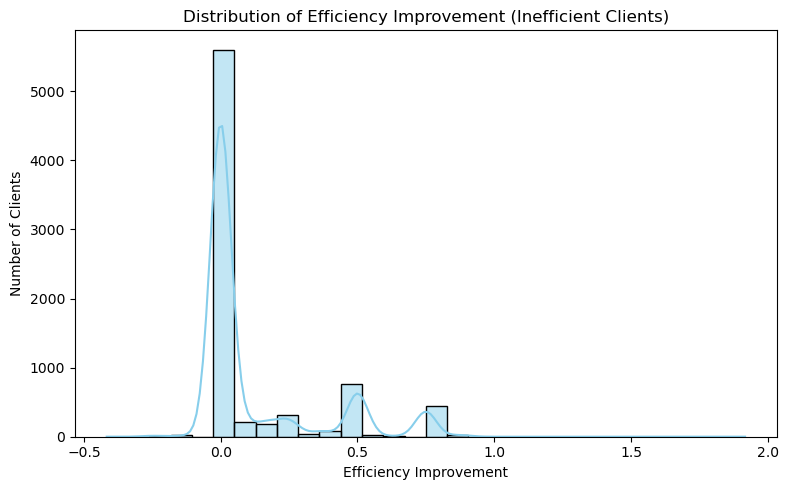

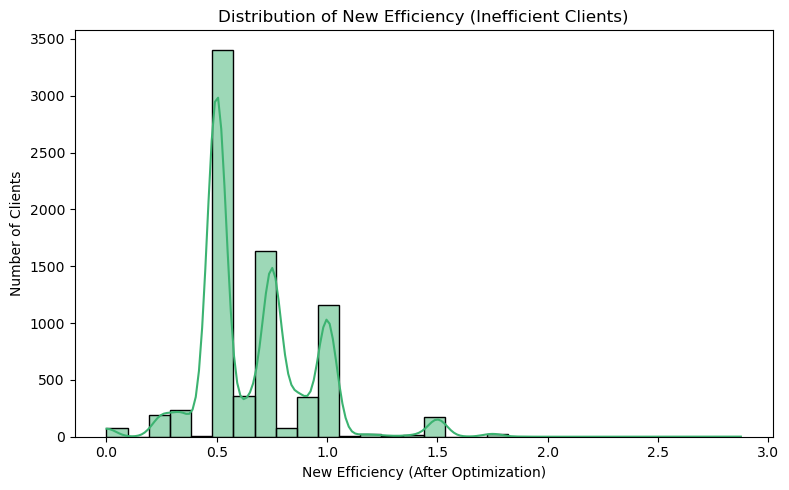

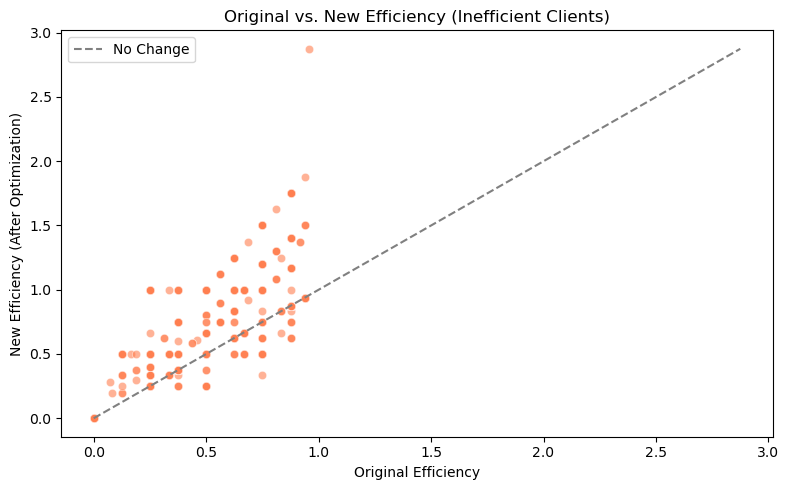

In [227]:
# Display the results for inefficient clients: show key columns and summary statistics
import seaborn as sns
import matplotlib.pyplot as plt

# Fix: Use the correct column name for predicted optimal visits
display_cols = [
    'client_id', 'new_efficiency', 'efficiency_improvement','visits_saved',
    'median_promotor_visits', 'predicted_optimal_visits'
]

print("Sample of inefficient clients with current number of visits, predicted optimal visits, and efficiency improvement:")
try:
    display(inefficient_clients[display_cols].head(10))
except KeyError as e:
    print(f"KeyError: {e}")
    print("Available columns:", inefficient_clients.columns.tolist())

# --- Ranking: Top 10 most improved clients ---
print("\nTop 10 inefficient clients with the highest efficiency improvement:")
top_improved = inefficient_clients.sort_values('efficiency_improvement', ascending=False).head(10)
try:
    display(top_improved[display_cols])
except KeyError as e:
    print(f"KeyError: {e}")
    print("Available columns:", top_improved.columns.tolist())

# --- Visualization 1: Distribution of efficiency improvement ---
plt.figure(figsize=(8, 5))
sns.histplot(inefficient_clients['efficiency_improvement'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Efficiency Improvement (Inefficient Clients)')
plt.xlabel('Efficiency Improvement')
plt.ylabel('Number of Clients')
plt.tight_layout()
plt.show()

# --- Visualization 1b: Distribution of new efficiency ---
plt.figure(figsize=(8, 5))
sns.histplot(inefficient_clients['new_efficiency'], bins=30, kde=True, color='mediumseagreen')
plt.title('Distribution of New Efficiency (Inefficient Clients)')
plt.xlabel('New Efficiency (After Optimization)')
plt.ylabel('Number of Clients')
plt.tight_layout()
plt.show()

# --- Visualization 2: Scatter plot of original vs. new efficiency ---
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=inefficient_clients,
    x='efficiency',
    y='new_efficiency',
    alpha=0.6,
    color='coral'
)
max_val = max(inefficient_clients['efficiency'].max(), inefficient_clients['new_efficiency'].max())
plt.plot([0, max_val], [0, max_val], ls='--', color='gray', label='No Change')
plt.title('Original vs. New Efficiency (Inefficient Clients)')
plt.xlabel('Original Efficiency')
plt.ylabel('New Efficiency (After Optimization)')
plt.legend()
plt.tight_layout()
plt.show()


### Savings

In [228]:
import pandas as pd
import numpy as np

# \--- 1. Estimate the Cost Per Visit ---

# We'll create a new column for the estimated cost of a single promoter visit.

# To avoid division by zero errors for clients with no visits, we handle it carefully.

inefficient_clients['avg_cost_per_visit'] = (inefficient_clients['total_cost'] / inefficient_clients['total_promotor_visits']).replace([np.inf, -np.inf], 0).fillna(0)

# \--- 2. Calculate Potential Savings for Over-served Clients ---

# Initialize a new column for savings.

inefficient_clients['potential_savings'] = 0.0
visit_cost = 15 #EUR per visit

inefficient_clients['potential_savings'] = inefficient_clients['visits_saved'] * visit_cost

# We only calculate savings for clients where the visit\_gap is negative (i.e., they are over-served).

# --- 3. Analyze and Display the Savings Results ---

# Calculate the total potential savings across all over-served clients

total_potential_savings = inefficient_clients['potential_savings'].sum()

print(f"--- Cost-Saving Analysis ---")
print(f"Total Potential Savings by reducing visits to over-served clients: ${total_potential_savings:,.2f}")

# Rank the clients by the highest potential savings

top_savings_clients = inefficient_clients.sort_values('potential_savings', ascending=False)

# Define the columns for a clear report

display_cols_savings = [
'client_id',
'frequency',
'predicted_optimal_visits',
'visits_saved',
'cost_per_visit',
'potential_savings'
]

print("\n--- Top 10 Clients with the Highest Potential Savings ---")
display(top_savings_clients[display_cols_savings].head(10))

--- Cost-Saving Analysis ---
Total Potential Savings by reducing visits to over-served clients: $51,180.00

--- Top 10 Clients with the Highest Potential Savings ---


KeyError: "['cost_per_visit'] not in index"

### Summary

In [ ]:
# Efficiency Improvement Metrics
print("=== EFFICIENCY IMPROVEMENT METRICS ===")
print(f"Total clients analyzed: {len(inefficient_clients)}")
print(f"Average efficiency improvement: {inefficient_clients['efficiency_improvement'].mean():.3f}")
print(f"Median efficiency improvement: {inefficient_clients['efficiency_improvement'].median():.3f}")
print(f"Maximum efficiency improvement: {inefficient_clients['efficiency_improvement'].max():.3f}")
print(f"Standard deviation of efficiency improvement: {inefficient_clients['efficiency_improvement'].std():.3f}")

# Optimized Order Metrics
print("\n=== OPTIMIZED ORDER METRICS ===")
print(f"Total visits that can be saved: {inefficient_clients['visits_saved'].sum():.0f}")
print(f"Average visits saved per client: {inefficient_clients['visits_saved'].mean():.2f}")
print(f"Median visits saved per client: {inefficient_clients['visits_saved'].median():.2f}")
print(f"Maximum visits saved by a single client: {inefficient_clients['visits_saved'].max():.0f}")

# Savings Analysis
print("\n=== SAVINGS ANALYSIS ===")
print(f"Total potential savings: €{total_potential_savings:,.2f}")
print(f"Average savings per client: €{inefficient_clients['potential_savings'].mean():.2f}")
print(f"Median savings per client: €{inefficient_clients['potential_savings'].median():.2f}")
print(f"Maximum savings by a single client: €{inefficient_clients['potential_savings'].max():.2f}")

# Distribution of savings
print(f"\nSavings distribution:")
print(f"Clients with savings > €100: {(inefficient_clients['potential_savings'] > 100).sum()}")
print(f"Clients with savings > €50: {(inefficient_clients['potential_savings'] > 50).sum()}")
print(f"Clients with savings > €25: {(inefficient_clients['potential_savings'] > 25).sum()}")

# Summary table
print("\n=== SUMMARY TABLE ===")
summary_data = {
    'Metric': ['Total Clients', 'Total Visits Saved', 'Total Savings (€)'],
    'Value': [
        len(inefficient_clients),
        f"{inefficient_clients['visits_saved'].sum():.0f}",
        f"€{total_potential_savings:,.2f}",
    ]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)


=== EFFICIENCY IMPROVEMENT METRICS ===
Total clients analyzed: 7799
Average efficiency improvement: 0.123
Median efficiency improvement: 0.000
Maximum efficiency improvement: 1.125
Standard deviation of efficiency improvement: 0.228

=== OPTIMIZED ORDER METRICS ===
Total visits that can be saved: 3395
Average visits saved per client: 0.44
Median visits saved per client: 0.00
Maximum visits saved by a single client: 22

=== SAVINGS ANALYSIS ===
Total potential savings: €50,925.00
Average savings per client: €6.53
Median savings per client: €0.00
Maximum savings by a single client: €330.00

Savings distribution:
Clients with savings > €100: 5
Clients with savings > €50: 40
Clients with savings > €25: 797

=== SUMMARY TABLE ===


,Metric,Value
0,Total Clients,7799
1,Total Visits Saved,3395
2,Total Savings (€),"€50,925.00"
